In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#note: depending on how you installed (e.g., using source code download versus pip install), you may need to import like this:
#from vaderSentiment import SentimentIntensityAnalyzer

# --- examples -------
sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "VADER is very smart, handsome, and funny.", # booster words handled correctly (sentiment intensity adjusted)
             "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
             "VADER is VERY SMART, handsome, and FUNNY!!!", # combination of signals - VADER appropriately adjusts intensity
             "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!", # booster words & punctuation make this close to ceiling for score
             "VADER is not smart, handsome, nor funny.",  # negation sentence example
             "The book was good.",  # positive sentence
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled
             "Not bad at all"  # Capitalized negation
             ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

VADER is smart, handsome, and funny.----------------------------- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is smart, handsome, and funny!----------------------------- {'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'compound': 0.8439}
VADER is very smart, handsome, and funny.------------------------ {'neg': 0.0, 'neu': 0.299, 'pos': 0.701, 'compound': 0.8545}
VADER is VERY SMART, handsome, and FUNNY.------------------------ {'neg': 0.0, 'neu': 0.246, 'pos': 0.754, 'compound': 0.9227}
VADER is VERY SMART, handsome, and FUNNY!!!---------------------- {'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.9342}
VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!--------- {'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.9469}
VADER is not smart, handsome, nor funny.------------------------- {'neg': 0.646, 'neu': 0.354, 'pos': 0.0, 'compound': -0.7424}
The book was good.----------------------------------------------- {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'co

# Import and Get Buckets

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import tqdm
import pandas as pd
import json
import os


# Set the Reddit Data File Path (JSON)
data_file_path = "data/florida_comments.json"

time_interval_seconds = 2 * 30 * 24 * 60 * 60 # two months
time_start = 1546300801 # 1st January 2019
time_end = 1672531201 # 1st January 2023

activity_bucket_limits = [1, 10, 100, 1000, 10000, 100000, 1000000] # Inclusive on lower bound, exclusive on upper bound - strictly integers


# Group the users into buckets based on activity during each time interval
# Create a list of dictionaries the following format: (the index in the list is the time bucket index)
# [{user_id: posts_during_time_interval, user_id: posts_during_time_interval, ...}, 
#  {user_id: posts_during_time_interval, user_id: posts_during_time_interval, ...}, ...]

# Initialise a list of empty dictionaries of the amount of time intervals
activity_buckets = [{} for i in range(int((time_end - time_start) / time_interval_seconds) + 1)]

# Initialise progress bar
pbar = tqdm.tqdm(total=os.path.getsize(data_file_path))

# Iterate through the data file
with open(data_file_path) as data_file:
    # Analyse each line in the data file
    for line in data_file:
        # Load the line as a JSON object
        line_json = json.loads(line)
        
        # Get the timestamp of the comment
        timestamp = int(line_json["created_utc"])
        user_id = line_json["author"]

        # Check if within start and end time
        if timestamp < time_start or timestamp > time_end:
            # Update the progress bar
            pbar.update(len(line))
            continue
        
        # Get the time interval index
        time_interval_index = int((timestamp - time_start) / time_interval_seconds)

        # Check if the user has already been added to the activity bucket
        if user_id in activity_buckets[time_interval_index]:
            # Increment the user's post count
            activity_buckets[time_interval_index][user_id] += 1
        else:
            # Add the user to the activity bucket
            activity_buckets[time_interval_index][user_id] = 1

        # Update the progress bar
        pbar.update(len(line))

# Close the progress bar
pbar.close()

# Initialise another progress bar
pbar = tqdm.tqdm(total=len(activity_buckets))

# Change the activity count into bucket indices
for time_bucket in activity_buckets:
    # Update the progress bar
    pbar.update(1)
    for user in time_bucket:
        # Iterate through the activity bucket limits
        for i in range(len(activity_bucket_limits)):
            # Using the activity bucket limits, find the bucket index
            if time_bucket[user] >= activity_bucket_limits[i] and time_bucket[user] < activity_bucket_limits[i + 1]:
                # Set the activity bucket to the bucket index
                time_bucket[user] = i
                break


# Close the progress bar
pbar.close()


100%|██████████| 25/25 [00:00<00:00, 108.08it/s]


In [3]:
# Set the CSV file path
csv_file_path = f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LIWC.csv'

run_CSV_creation = True

if run_CSV_creation:
    # Intialise the progress bar based on the number of items in the data file
    with open(data_file_path) as f:
        num_lines = sum(1 for line in f)

    pbar = tqdm.tqdm(total=num_lines)

    # Read the data file and add the data to the csv file
    with open(data_file_path) as f:
        with open(csv_file_path, 'w') as csv_file:

            # Clear the csv file of any existing data
            csv_file.truncate(0)

            for line in f:
                Sentiment_by_bucket = json.loads(line)
                utc_timestamp = Sentiment_by_bucket['created_utc']
                LIWC_categories = analyzer.polarity_scores(Sentiment_by_bucket['body'])
                author = Sentiment_by_bucket['author']

                # Check if post is within the time interval
                if int(utc_timestamp) < time_start or int(utc_timestamp) > time_end:
                    pbar.update(1)
                    continue

                # Determine the activity bucket index
                time_interval_index = int((int(utc_timestamp) - time_start) / time_interval_seconds)
                activity_buckets_index = activity_buckets[time_interval_index][author]

                # Write the data to the csv file
                csv_file.write(f'{utc_timestamp},"{LIWC_categories}", {activity_buckets_index}\n')

                # Update the progress bar
                pbar.update(1)
            

    # Close the progress bar
    pbar.close()


100%|██████████| 1293082/1293082 [10:53<00:00, 1978.47it/s]


In [4]:
# Load the data from the csv file into a dataframe
df = pd.read_csv(csv_file_path)

# Add headers to the dataframe
df.columns = ['utc_timestamp', 'Sentiment', 'activity_bucket_index']

df.head()

,utc_timestamp,Sentiment,activity_bucket_index
0,1546301518,"{'neg': 0.034, 'neu': 0.87, 'pos': 0.096, 'com...",1
1,1546301651,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",1
2,1546301940,"{'neg': 0.049, 'neu': 0.76, 'pos': 0.19, 'comp...",0
3,1546301963,"{'neg': 0.399, 'neu': 0.286, 'pos': 0.315, 'co...",1
4,1546302157,"{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'comp...",0


In [5]:
import numpy as np

# Calculate time bucket intervals
time_buckets = range(int(time_start), int(time_end) + int(time_interval_seconds), int(time_interval_seconds))


# Change the utc_timestamp to the bucket number, e.g. the 0th bucket is between the 0th index and the 1st index of the time_buckets
df['utc_timestamp'] = df['utc_timestamp'].apply(lambda x: np.searchsorted(time_buckets, x) - 1)


df.head()

,utc_timestamp,Sentiment,activity_bucket_index
0,0,"{'neg': 0.034, 'neu': 0.87, 'pos': 0.096, 'com...",1
1,0,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",1
2,0,"{'neg': 0.049, 'neu': 0.76, 'pos': 0.19, 'comp...",0
3,0,"{'neg': 0.399, 'neu': 0.286, 'pos': 0.315, 'co...",1
4,0,"{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'comp...",0


In [6]:
# Create a dict of series in the form {activity_bucket_index: Average Compound Score Series For Each Time Bucket Series}
# The series is an array of the average compound score for each time bucket

# Initialise the dict
activity_bucket_dict_compound = {}
activity_bucket_dict_pos = {}
activity_bucket_dict_neu = {}
activity_bucket_dict_neg = {}

# Initialise the progress bar
pbar = tqdm.tqdm(total=len(activity_bucket_limits))

# Iterate through the activity bucket indices
for activity_bucket_index in range(len(activity_bucket_limits)):

    # Iterate through the time buckets
    for time_bucket in range(len(time_buckets) - 1):
        # Get the rows of the dataframe that match the activity bucket index and the time bucket
        df_activity_bucket_time_bucket = df[(df['activity_bucket_index'] == activity_bucket_index) & (df['utc_timestamp'] == time_bucket)]

        # If there are no rows, add a 0 to the dict
        if len(df_activity_bucket_time_bucket) == 0:
            if activity_bucket_index in activity_bucket_dict_compound:
                activity_bucket_dict_compound[activity_bucket_index].append(0)
            else:
                activity_bucket_dict_compound[activity_bucket_index] = [0]

            if activity_bucket_index in activity_bucket_dict_neg:
                activity_bucket_dict_neg[activity_bucket_index].append(0)
            else:
                activity_bucket_dict_neg[activity_bucket_index] = [0]

            if activity_bucket_index in activity_bucket_dict_neu:
                activity_bucket_dict_neu[activity_bucket_index].append(0)
            else:
                activity_bucket_dict_neu[activity_bucket_index] = [0]

            if activity_bucket_index in activity_bucket_dict_pos:
                activity_bucket_dict_pos[activity_bucket_index].append(0)
            else:
                activity_bucket_dict_pos[activity_bucket_index] = [0]
            continue

        sentiment_series_compound = []
        sentiment_series_pos = []
        sentiment_series_neu = []
        sentiment_series_neg = []

        # Iterate through the rows
        for index, row in df_activity_bucket_time_bucket.iterrows():
            # Get the sentiment series
            sentiment_series_compound.append(eval(row['Sentiment'])['compound'])
            sentiment_series_pos.append(eval(row['Sentiment'])['pos'])
            sentiment_series_neu.append(eval(row['Sentiment'])['neu'])
            sentiment_series_neg.append(eval(row['Sentiment'])['neg'])
        
        # Calculate the average compound score
        average_compound_score = np.mean(sentiment_series_compound)
        average_pos_score = np.mean(sentiment_series_pos)
        average_neu_score = np.mean(sentiment_series_neu)
        average_neg_score = np.mean(sentiment_series_neg)

        # Add the average compound score to the dict
        if activity_bucket_index in activity_bucket_dict_compound:
            activity_bucket_dict_compound[activity_bucket_index].append(average_compound_score)
        else:
            activity_bucket_dict_compound[activity_bucket_index] = [average_compound_score]

        if activity_bucket_index in activity_bucket_dict_neg:
            activity_bucket_dict_neg[activity_bucket_index].append(average_neg_score)
        else:
            activity_bucket_dict_neg[activity_bucket_index] = [average_neg_score]

        if activity_bucket_index in activity_bucket_dict_neu:
            activity_bucket_dict_neu[activity_bucket_index].append(average_neu_score)
        else:
            activity_bucket_dict_neu[activity_bucket_index] = [average_neu_score]

        if activity_bucket_index in activity_bucket_dict_pos:
            activity_bucket_dict_pos[activity_bucket_index].append(average_pos_score)
        else:
            activity_bucket_dict_pos[activity_bucket_index] = [average_pos_score]


    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()

print(activity_bucket_dict_compound)

# Typical Run Time: 3 minutes 40 seconds

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [06:49<00:00, 58.44s/it] 

{0: [0.10034112519809826, 0.13457206436648303, 0.13182995183624324, 0.10588480492813142, 0.11258594723134413, 0.10125152976639036, 0.13011132626402336, 0.06540236601541495, 0.07903636864512899, 0.06411429238891746, 0.10469170835228134, 0.10917934927424446, 0.1379956497438286, 0.11418550162324807, 0.09782874817081282, 0.07582420822022193, 0.08028204298449139, 0.11912577962577961, 0.10062176414189837, 0.07691397718202732, 0.08438999044159816, 0.08527305260182995, 0.07262795539819268, 0.08681513423285575, 0.11568701153703015], 1: [0.0712310701256587, 0.09133807339449541, 0.08229576179091501, 0.06491077902988732, 0.0818753144654088, 0.07382514150943396, 0.11478633949826038, 0.03280024158993527, 0.05354271491479992, 0.036078981898930086, 0.0778679201223931, 0.06835072028281042, 0.10885495294700347, 0.10106585040495474, 0.07716636401732085, 0.051635068815646515, 0.05805244964262508, 0.0800598091691878, 0.06226643659711076, 0.04617797778935974, 0.04515693017296605, 0.07097970316437972, 0.0616

# Spearman Testing

In [7]:
# Print the positive and negative dictionaries
print(activity_bucket_dict_pos)
print(activity_bucket_dict_neg)

VADER_activity_bucket_dict_pos = activity_bucket_dict_pos
VADER_activity_bucket_dict_neg = activity_bucket_dict_neg

{0: [0.12705911251980984, 0.13921875906059727, 0.14311634557495484, 0.13182340862422998, 0.13549801834446834, 0.13054860587792014, 0.14019963116643613, 0.12164796558523033, 0.1255053343350864, 0.12525874877353643, 0.139410338032439, 0.13666061286024825, 0.14961397298556126, 0.14319106817641936, 0.137535319941466, 0.12901885983711958, 0.1325948833801441, 0.13437694906444905, 0.1316976669862576, 0.12285736419550214, 0.12592632383865418, 0.1228220228212103, 0.12249231094435344, 0.12130484072889137, 0.1252157610718273], 1: [0.12177178759627078, 0.12718587953729557, 0.12312888502499456, 0.11960044096031357, 0.12373490566037737, 0.12607971698113207, 0.13068540560336936, 0.1147479259731972, 0.11672617269768333, 0.11681417804992934, 0.12395418310653034, 0.1320179407865665, 0.13885190688459637, 0.13699075750357312, 0.12789020812962704, 0.12236114632379572, 0.12877283950617283, 0.12319882088278644, 0.1227346709470305, 0.11825305696989136, 0.1189027546444587, 0.11977275273032764, 0.12034365432913

## Getting the LIWC Data

In [47]:
time_interval_seconds = 2 * 30 * 24 * 60 * 60 # two months
time_start = 1546300801 # 1st January 2019
time_end = 1672531201 # 1st January 2023

activity_bucket_limits = [1, 10, 100, 1000, 10000, 100000, 1000000] # Inclusive on lower bound, exclusive on upper bound - strictly integers

In [48]:
import liwc
parse, category_names = liwc.load_token_parser('dictionaries/LIWC07-EN.dic')

In [49]:
import re
from collections import Counter

def tokenize(text):
    # you may want to use a smarter tokenizer
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)

def count_categories(text):
    # Returns a Counter object containing tallies of all LIWC categories
    text = text.lower()

    # Remove all words in text that are less than 3 characters long
    text = re.sub(r'\b\w{1,3}\b', '', text)

    # Remove "[removed]" and "[deleted]" from the body text
    text = re.sub(r'\[removed\]|\[deleted\]', '', text)
    
    tokens = tokenize(text)
    counter = Counter(category for token in tokens for category in parse(token))

    # If a category doesn't exist in the text, we need to add it and set the count to 0
    for category in category_names:
        if category not in counter:
            counter[category] = 0



    return counter

gettysburg = "hello world, this [removed]"

print(count_categories(gettysburg))

Counter({'social': 1, 'relativ': 1, 'space': 1, 'funct': 1, 'pronoun': 1, 'ipron': 1, 'ppron': 0, 'i': 0, 'we': 0, 'you': 0, 'shehe': 0, 'they': 0, 'article': 0, 'verb': 0, 'auxverb': 0, 'past': 0, 'present': 0, 'future': 0, 'adverb': 0, 'preps': 0, 'conj': 0, 'negate': 0, 'quant': 0, 'number': 0, 'swear': 0, 'family': 0, 'friend': 0, 'humans': 0, 'affect': 0, 'posemo': 0, 'negemo': 0, 'anx': 0, 'anger': 0, 'sad': 0, 'cogmech': 0, 'insight': 0, 'cause': 0, 'discrep': 0, 'tentat': 0, 'certain': 0, 'inhib': 0, 'incl': 0, 'excl': 0, 'percept': 0, 'see': 0, 'hear': 0, 'feel': 0, 'bio': 0, 'body': 0, 'health': 0, 'sexual': 0, 'ingest': 0, 'motion': 0, 'time': 0, 'work': 0, 'achieve': 0, 'leisure': 0, 'home': 0, 'money': 0, 'relig': 0, 'death': 0, 'assent': 0, 'nonfl': 0, 'filler': 0})


In [50]:
import tqdm
import pandas as pd
import json
import os


# Group the users into buckets based on activity during each time interval
# Create a list of dictionaries the following format: (the index in the list is the time bucket index)
# [{user_id: posts_during_time_interval, user_id: posts_during_time_interval, ...}, 
#  {user_id: posts_during_time_interval, user_id: posts_during_time_interval, ...}, ...]

# Initialise a list of empty dictionaries of the amount of time intervals
activity_buckets = [{} for i in range(int((time_end - time_start) / time_interval_seconds) + 1)]

# Initialise progress bar
pbar = tqdm.tqdm(total=os.path.getsize(data_file_path))

# Iterate through the data file
with open(data_file_path) as data_file:
    # Analyse each line in the data file
    for line in data_file:
        # Load the line as a JSON object
        line_json = json.loads(line)
        
        # Get the timestamp of the comment
        timestamp = int(line_json["created_utc"])
        user_id = line_json["author"]

        # Check if within start and end time
        if timestamp < time_start or timestamp > time_end:
            # Update the progress bar
            pbar.update(len(line))
            continue
        
        # Get the time interval index
        time_interval_index = int((timestamp - time_start) / time_interval_seconds)

        # Check if the user has already been added to the activity bucket
        if user_id in activity_buckets[time_interval_index]:
            # Increment the user's post count
            activity_buckets[time_interval_index][user_id] += 1
        else:
            # Add the user to the activity bucket
            activity_buckets[time_interval_index][user_id] = 1

        # Update the progress bar
        pbar.update(len(line))

# Close the progress bar
pbar.close()

# Initialise another progress bar
pbar = tqdm.tqdm(total=len(activity_buckets))

# Change the activity count into bucket indices
for time_bucket in activity_buckets:
    # Update the progress bar
    pbar.update(1)
    for user in time_bucket:
        # Iterate through the activity bucket limits
        for i in range(len(activity_bucket_limits)):
            # Using the activity bucket limits, find the bucket index
            if time_bucket[user] >= activity_bucket_limits[i] and time_bucket[user] < activity_bucket_limits[i + 1]:
                # Set the activity bucket to the bucket index
                time_bucket[user] = i
                break


# Close the progress bar
pbar.close()

activity_buckets

100%|██████████| 25/25 [00:00<00:00, 52.90it/s] 


[{'krissime': 0,
  'Texan_Greyback': 1,
  'loficiti': 0,
  'sophiabrat': 0,
  'o_g': 0,
  'shadowspawn': 1,
  'BabyT-RexArms': 0,
  'QcumberKid': 0,
  'trailorparkprincess': 0,
  'EssArrBee': 0,
  'Cool_Ranch_Dodrio': 2,
  'BiscuitHead3000': 0,
  'M6D_Magnum': 1,
  'Tannerbkelly': 0,
  'AGreenSmudge': 1,
  'Anthonyzzzzz': 0,
  'sisimartini28': 0,
  'winethief': 0,
  'MEGAYACHT': 0,
  'bgadds': 0,
  'ThickPrick': 0,
  'CorinthWest': 1,
  'Chemspiration': 0,
  'Kemah': 0,
  'Aggieann': 0,
  'iLLBrasky82': 0,
  'preshred': 0,
  'HydRO-7': 0,
  'FortressMost': 0,
  'Slummish': 1,
  'HagalinaMagalina': 0,
  'flagautism': 1,
  'HHO980': 0,
  'Steak_Knight': 1,
  'quiltsohard': 1,
  'tacol00t': 0,
  'alltheprettysongs': 0,
  'I_am_who': 0,
  '[deleted]': 3,
  'PerilousAll': 1,
  'Geaux_joel': 0,
  'MarcProust': 1,
  'SeaTurtleAss': 0,
  'leighroda82': 0,
  'Hufflypuffly723': 0,
  'ripster65': 1,
  'ZRodri8': 2,
  'ChilrenOfAnEldridGod': 1,
  'mrtie007': 0,
  'noodlespork': 0,
  'earthwirmjim'

In [51]:
run_CSV_creation = True

if run_CSV_creation:
    # Intialise the progress bar based on the number of items in the data file
    with open(data_file_path) as f:
        num_lines = sum(1 for line in f)

    pbar = tqdm.tqdm(total=num_lines)

    # Read the data file and add the data to the csv file
    with open(data_file_path) as f:
        with open(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LIWC.csv', 'w') as csv_file:

            # Clear the csv file of any existing data
            csv_file.truncate(0)

            for line in f:
                LIWC_by_bucket = json.loads(line)
                utc_timestamp = LIWC_by_bucket['created_utc']
                body_text = LIWC_by_bucket['body']
                LIWC_categories = count_categories(body_text)
                author = LIWC_by_bucket['author']

                # Check if post is within the time interval
                if int(utc_timestamp) < time_start or int(utc_timestamp) > time_end:
                    pbar.update(1)
                    continue

                # Determine the activity bucket index
                time_interval_index = int((int(utc_timestamp) - time_start) / time_interval_seconds)
                activity_buckets_index = activity_buckets[time_interval_index][author]

                # Cleanse the body_text of any newlines, commas, and quotation marks, and replace them with spaces
                body_text = body_text.replace('\n', ' ').replace(',', ' ').replace('"', ' ')


                # Write the data to the csv file
                csv_file.write(f'{utc_timestamp},"{LIWC_categories}", {activity_buckets_index}, "{body_text}"\n')

                # Update the progress bar
                pbar.update(1)
            

    # Close the progress bar
    pbar.close()


100%|██████████| 2684972/2684972 [12:13<00:00, 3662.95it/s]


In [52]:
# Load the data from the csv file into a dataframe
df = pd.read_csv(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LIWC.csv', lineterminator='\n')

# Add headers to the dataframe
df.columns = ['utc_timestamp', 'LIWC_categories', 'activity_bucket_index', 'body_text']

df.head()

,utc_timestamp,LIWC_categories,activity_bucket_index,body_text
0,1546300972,"Counter({'funct': 3, 'pronoun': 2, 'ipron': 2,...",1,"""Ok I'm sorry but what does that mean?"""
1,1546300987,"Counter({'funct': 1, 'adverb': 1, 'cogmech': 1...",0,"""Just swap the vanilla for pistachio and the ..."
2,1546301166,"Counter({'percept': 3, 'verb': 2, 'past': 2, '...",0,"""It looked like a watercolor painting didn’t ..."
3,1546301171,"Counter({'space': 1, 'relativ': 1, 'cogmech': ...",0,"""It's Hale Center. And you forgot Plainview ..."
4,1546301292,"Counter({'verb': 1, 'present': 1, 'cogmech': 1...",1,"""Now I want steak fried in oleo. """


In [53]:
import numpy as np

# Calculate time bucket intervals
time_buckets = range(int(time_start), int(time_end) + int(time_interval_seconds), int(time_interval_seconds))

# Print maximum utc_timestamp
# print(df['utc_timestamp'].max())
# print("------------------")
# print(*time_buckets, sep='\n')


# Change the utc_timestamp to the bucket number, e.g. the 0th bucket is between the 0th index and the 1st index of the time_buckets
df['utc_timestamp'] = df['utc_timestamp'].apply(lambda x: np.searchsorted(time_buckets, x) - 1)


df.head()

,utc_timestamp,LIWC_categories,activity_bucket_index,body_text
0,0,"Counter({'funct': 3, 'pronoun': 2, 'ipron': 2,...",1,"""Ok I'm sorry but what does that mean?"""
1,0,"Counter({'funct': 1, 'adverb': 1, 'cogmech': 1...",0,"""Just swap the vanilla for pistachio and the ..."
2,0,"Counter({'percept': 3, 'verb': 2, 'past': 2, '...",0,"""It looked like a watercolor painting didn’t ..."
3,0,"Counter({'space': 1, 'relativ': 1, 'cogmech': ...",0,"""It's Hale Center. And you forgot Plainview ..."
4,0,"Counter({'verb': 1, 'present': 1, 'cogmech': 1...",1,"""Now I want steak fried in oleo. """


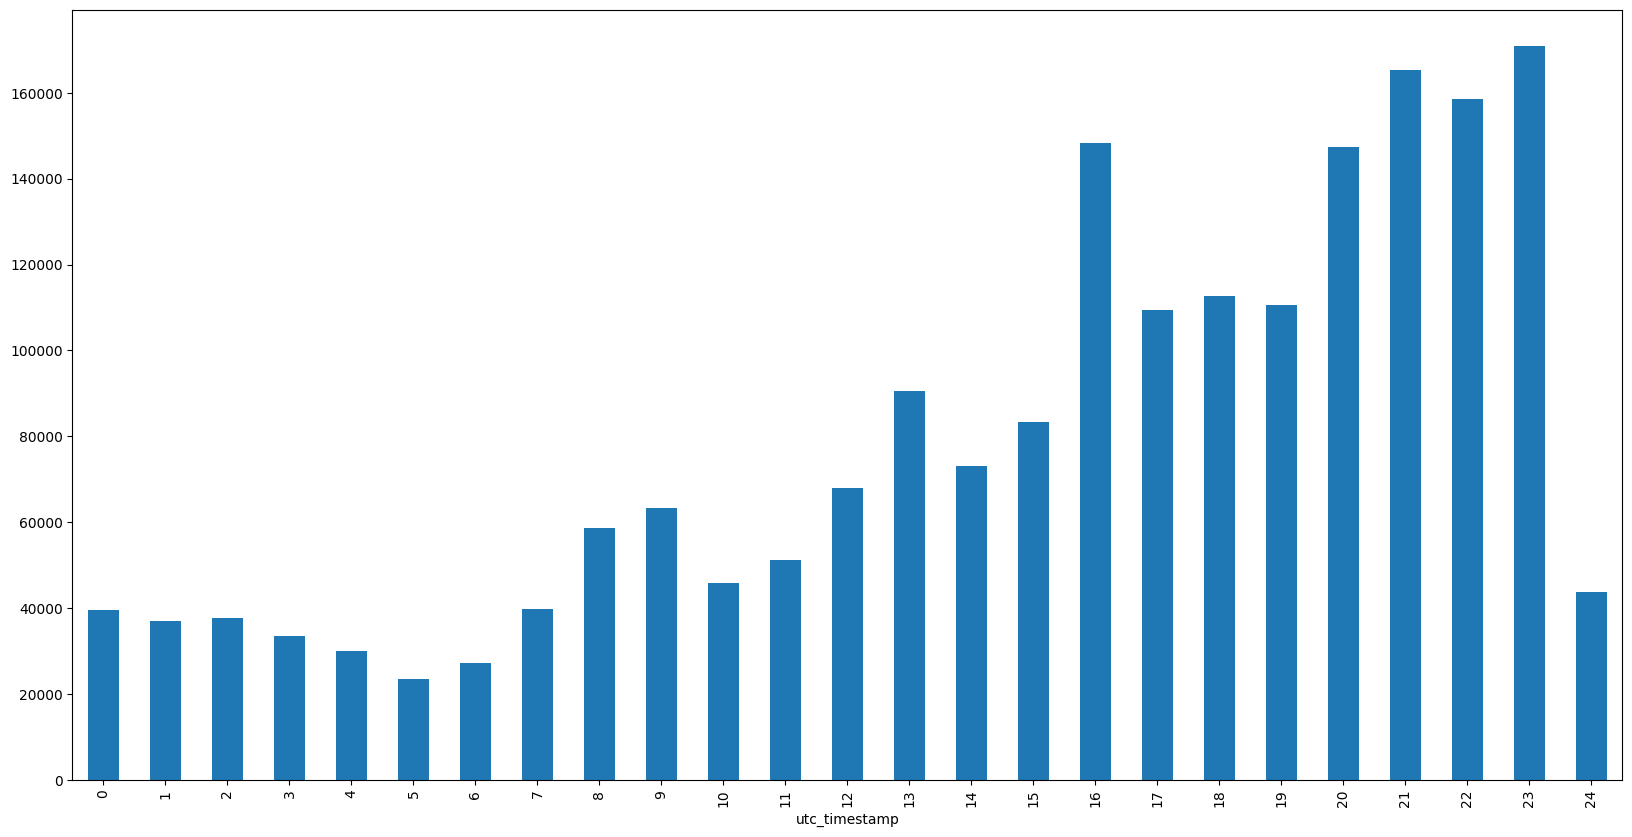

In [54]:
# Graph the number of comments per time bucket
import matplotlib.pyplot as plt

# Delete all rows with a utc_timestamp of -1
df = df[df['utc_timestamp'] != -1]

df['utc_timestamp'].value_counts().sort_index().plot(kind='bar', figsize=(20, 10))
plt.show()

In [55]:
# The LIWC categories stored in a list
data = [
    'funct', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they',
    'ipron', 'article', 'verb', 'auxverb', 'past', 'present', 'future',
    'adverb', 'preps', 'conj', 'negate', 'quant', 'number', 'swear',
    'social', 'family', 'friend', 'humans', 'affect', 'posemo',
    'negemo', 'anx', 'anger', 'sad', 'cogmech', 'insight', 'cause',
    'discrep', 'tentat', 'certain', 'inhib', 'incl', 'excl', 'percept',
    'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest',
    'relativ', 'motion', 'space', 'time', 'work', 'achieve', 'leisure',
    'home', 'money', 'relig', 'death', 'assent', 'nonfl', 'filler'
]

category = 'posemo'

# Construct a dictionary with the value in the form of a nested list, and the key as the LIWC category
# where the outer index is the activity_bucket_index, and the inner index is the time_bucket_index
# {LIWC_category: [[time_bucket_0, time_bucket_1, ...], [time_bucket_0, time_bucket_1, ...], ...]}

# Initialise the dictionary
LIWC_category_dict_pos = {}

# Initialise the dictionary with empty nested lists
LIWC_category_dict_pos = {category: [[0 for _ in time_buckets] for _ in activity_bucket_limits] for category in data}

print(LIWC_category_dict_pos)

# Start a progress bar
pbar = tqdm.tqdm(total=len(df))

# Iterate through each entry in df and aggregate the LIWC categories for each time_bucket
for index, row in df.iterrows():
    # Get the time_bucket and LIWC_categories
    time_bucket = row['utc_timestamp']
    LIWC_categories = row['LIWC_categories']
    activity_bucket_index = row['activity_bucket_index']

    # Convert the LIWC_categories string to a dictionary
    LIWC_categories = eval(LIWC_categories)

    # A percentage of all LIWC words must be the selected category
    # Check that LIWC_categories[selected_category] is not zero to avoid division by zero
    if LIWC_categories[category] != 0:
        if not LIWC_categories[category] / sum(LIWC_categories.values()) > 0.05:
            # Update the progress bar
            pbar.update(1)
            continue
            

    # For each row, go through the LIWC categories and add the time_bucket to the correct list
    for category in LIWC_categories:
        LIWC_category_dict_pos[category][activity_bucket_index][time_bucket] += (LIWC_categories[category])

    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()

LIWC_category_dict_pos

{'funct': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'pronoun': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 

100%|██████████| 1968638/1968638 [21:19<00:00, 1538.63it/s]


{'funct': [[65711,
   64536,
   68000,
   58351,
   55772,
   48920,
   49713,
   83193,
   115676,
   127474,
   87384,
   101479,
   164632,
   194015,
   139019,
   174062,
   272709,
   198458,
   200415,
   194152,
   269177,
   321852,
   282366,
   310052,
   117785,
   0],
  [68806,
   65999,
   70491,
   57054,
   55878,
   43939,
   48855,
   72927,
   121309,
   134913,
   86224,
   103749,
   132889,
   218378,
   171582,
   197133,
   363617,
   246999,
   253095,
   253494,
   391603,
   435606,
   386487,
   430746,
   103810,
   0],
  [46428,
   35188,
   25088,
   39575,
   28198,
   13473,
   24032,
   31683,
   55891,
   56781,
   36113,
   28468,
   20032,
   51710,
   54867,
   37804,
   110857,
   75966,
   62497,
   63016,
   129065,
   134107,
   117679,
   128226,
   8581,
   0],
  [9516,
   1988,
   4005,
   4631,
   5931,
   3351,
   3194,
   2976,
   5741,
   8432,
   7776,
   7901,
   0,
   10548,
   10308,
   8998,
   19428,
   15181,
   14613,
   17794,
 

In [56]:
print(LIWC_category_dict_pos)

{'funct': [[65711, 64536, 68000, 58351, 55772, 48920, 49713, 83193, 115676, 127474, 87384, 101479, 164632, 194015, 139019, 174062, 272709, 198458, 200415, 194152, 269177, 321852, 282366, 310052, 117785, 0], [68806, 65999, 70491, 57054, 55878, 43939, 48855, 72927, 121309, 134913, 86224, 103749, 132889, 218378, 171582, 197133, 363617, 246999, 253095, 253494, 391603, 435606, 386487, 430746, 103810, 0], [46428, 35188, 25088, 39575, 28198, 13473, 24032, 31683, 55891, 56781, 36113, 28468, 20032, 51710, 54867, 37804, 110857, 75966, 62497, 63016, 129065, 134107, 117679, 128226, 8581, 0], [9516, 1988, 4005, 4631, 5931, 3351, 3194, 2976, 5741, 8432, 7776, 7901, 0, 10548, 10308, 8998, 19428, 15181, 14613, 17794, 15265, 16526, 35696, 17995, 1006, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7058, 14188, 5269, 14158, 31090, 19273, 12827, 14208, 9381, 9227, 5312, 9685, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [57]:
LIWC_category_dict = LIWC_category_dict_pos

LIWC_category_dict_normalised = LIWC_category_dict

LIWC_category_sums = [[0 for _ in time_buckets] for _ in activity_bucket_limits]

for activity_bucket_index in range(len(activity_bucket_limits)):
    for time_bucket_index in range(len(time_buckets)):
        # Sum the LIWC categories for each activity and time bucket
        LIWC_category_sums[activity_bucket_index][time_bucket_index] = sum(LIWC_category_dict[category][activity_bucket_index][time_bucket_index] for category in data)

print(LIWC_category_dict_pos)


# Normalise the data by dividing each value by the total number of LIWC detected words in that activity and time bucket
for activity_bucket_index in range(len(activity_bucket_limits)):
    for time_bucket_index in range(len(time_buckets)):
        for category in data:
            # Normalise the data
            # If sum is zero, set to zero, otherwise divide
            if LIWC_category_sums[activity_bucket_index][time_bucket_index] == 0:
                LIWC_category_dict_normalised[category][activity_bucket_index][time_bucket_index] = 0
            else:
                LIWC_category_dict_normalised[category][activity_bucket_index][time_bucket_index] /= LIWC_category_sums[activity_bucket_index][time_bucket_index]



# {LIWC_category: [[time_bucket_0, time_bucket_1, ...], [time_bucket_0, time_bucket_1, ...], ...]}
LIWC_activity_bucket_dict_pos = LIWC_category_dict_normalised["posemo"]
LIWC_activity_bucket_dict_neg = LIWC_category_dict_normalised["negemo"]

# Print LIWC_activity_bucket_dict_pos and LIWC_activity_bucket_dict_neg
print("LIWC_activity_bucket_dicts")
print(LIWC_activity_bucket_dict_pos)
print(LIWC_activity_bucket_dict_neg)

# Print activity_bucket_dict_pos and activity_bucket_dict_neg
# Dict of series in the form {activity_bucket_index: Average Score Series For Each Time Bucket Series}
print("activity_bucket_dicts")
print(VADER_activity_bucket_dict_pos)
print(VADER_activity_bucket_dict_neg)

{'funct': [[65711, 64536, 68000, 58351, 55772, 48920, 49713, 83193, 115676, 127474, 87384, 101479, 164632, 194015, 139019, 174062, 272709, 198458, 200415, 194152, 269177, 321852, 282366, 310052, 117785, 0], [68806, 65999, 70491, 57054, 55878, 43939, 48855, 72927, 121309, 134913, 86224, 103749, 132889, 218378, 171582, 197133, 363617, 246999, 253095, 253494, 391603, 435606, 386487, 430746, 103810, 0], [46428, 35188, 25088, 39575, 28198, 13473, 24032, 31683, 55891, 56781, 36113, 28468, 20032, 51710, 54867, 37804, 110857, 75966, 62497, 63016, 129065, 134107, 117679, 128226, 8581, 0], [9516, 1988, 4005, 4631, 5931, 3351, 3194, 2976, 5741, 8432, 7776, 7901, 0, 10548, 10308, 8998, 19428, 15181, 14613, 17794, 15265, 16526, 35696, 17995, 1006, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7058, 14188, 5269, 14158, 31090, 19273, 12827, 14208, 9381, 9227, 5312, 9685, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [63]:
# Make the two data structures the same structure
# Make the VADER data structure from a dict to a list
VADER_activity_bucket_dict_pos = [VADER_activity_bucket_dict_pos[i] for i in range(len(VADER_activity_bucket_dict_pos))]
VADER_activity_bucket_dict_neg = [VADER_activity_bucket_dict_neg[i] for i in range(len(VADER_activity_bucket_dict_neg))]

# Check if the two data structures are the same length
print(f"Length of LIWC_activity_bucket_dict_pos: {len(LIWC_activity_bucket_dict_pos)}, Length of VADER_activity_bucket_dict_pos: {len(VADER_activity_bucket_dict_pos)}")

# Run a Spearman's Correlation Test on the two data structures for each activity bucket and for both positive and negative
from scipy.stats import spearmanr

# Initialise the list of spearmanr correlation coefficients
spearmanr_coefficients_pos = []
spearmanr_coefficients_neg = []

# Initialise the list of p-values
p_values_pos = []
p_values_neg = []

# Iterate through the activity buckets
for activity_bucket_index in range(len(activity_bucket_limits)):
    # Run the Spearman's Correlation Test
    spearmanr_coefficient_pos, p_value_pos = spearmanr(LIWC_activity_bucket_dict_pos[activity_bucket_index][0:24], VADER_activity_bucket_dict_pos[activity_bucket_index][0:24])
    spearmanr_coefficient_neg, p_value_neg = spearmanr(LIWC_activity_bucket_dict_neg[activity_bucket_index][0:24], VADER_activity_bucket_dict_neg[activity_bucket_index][0:24])

    # Add the coefficient to the list
    spearmanr_coefficients_pos.append(spearmanr_coefficient_pos)
    spearmanr_coefficients_neg.append(spearmanr_coefficient_neg)

    # Add the p-value to the list
    p_values_pos.append(p_value_pos)
    p_values_neg.append(p_value_neg)

# Pretty-print the spearmanr_coefficients
print("Spearman's Correlation Coefficients")
print(spearmanr_coefficients_pos)
print(spearmanr_coefficients_neg)

# Pretty-print the p-values
print("p-values")
print(p_values_pos)
print(p_values_neg)

Length of LIWC_activity_bucket_dict_pos: 7, Length of VADER_activity_bucket_dict_pos: 7
Spearman's Correlation Coefficients
[0.40347826086956523, 0.33304347826086955, -0.08086956521739129, 0.08061573200834075, 0.51162060312665, nan, nan]
[0.32347826086956516, 0.02869565217391304, -0.03913043478260869, -0.30143273707466545, 0.5076951253532997, nan, nan]
p-values
[0.05056591564642584, 0.11177657698587248, 0.707180750468238, 0.7080605026841713, 0.010604499022734122, nan, nan]
[0.12309527821926133, 0.8941129145750657, 0.855947935071337, 0.15230832646608353, 0.011322174297810279, nan, nan]


/home/jiuyzhan/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
